# Fundamental rythms analysis in SSVEPs as a quantifying measure for visual fatigue 

Python code for analysing one frequency range for one volunteer.


## Declaring libraries

In [2]:
%config Completer.use_jedi = False

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import json
from scipy import signal
from scipy.io import loadmat
from scipy.fft import fft, fftshift, fftfreq
from nested_dict import nested_dict
from mpl_toolkits import mplot3d

## Declaring variables

In [3]:
# Duration of the stimulus [seconds]
STIM_TIME = 10

# Number of electrodes
CHANNEL_QNT = 12

# Sample frequency [Hz]
F_S = 512

# Number of sample points neighboors to the stimulation frequency
N_SNR = 4

# Seconds
WND_SIZE = 2 

# Number of time windows
WND_NUMBER = 9

# Number of samples
NFFT = WND_SIZE*F_S

# Frequency step [Hz]
DELTA_F = F_S/NFFT

## Creating Pandas' dataframe

In [4]:
# Creating DataFrame from list with one dictionary for each stimulation frequency and
# the signals from each one of the 12 electrodes

# Opening data file
LOW_FREQ_SIGNAL = loadmat('/home/guilherme/pCloudDrive/pcloud/ifes/iniciacao/dados/Vol_1_LOW.mat')

SIGNAL_FREQ = [{
    # Stimulation frequency
    'freq': '',
    # 12 electrodes' signals
    'signals': [[] for i in range(CHANNEL_QNT)]
} for x in range(LOW_FREQ_SIGNAL['ans'].shape[1])]

# Inserting frequencies and signals in the list
for i in range(LOW_FREQ_SIGNAL['ans'].shape[1]):
    SIGNAL_FREQ[i]['freq'] = LOW_FREQ_SIGNAL['ans'][:,i][0][0][0][1][0][0]
    
    for x in range(CHANNEL_QNT):
        # Getting last 10 seconds of signal
        SIGNAL_FREQ[i]['signals'][x] = np.array(LOW_FREQ_SIGNAL['ans'][:,i][0][0][0][0][:,x][F_S*2:F_S*12])

# Creating dataframe
SIGNALS_DF = pd.DataFrame(SIGNAL_FREQ)

# Setting stimulation frequencies as the rows' indexes
SIGNALS_DF = SIGNALS_DF.set_index('freq')

# Setting frequency step = 0.5 by deleting rows not respecting it
for freq in SIGNALS_DF.index:
    if freq%0.5 != 0:
        SIGNALS_DF.drop(freq, inplace=True)

## Signals' pre-processing

### Declaring filters

In [5]:
# Bandpass filter
BANDWIDTH = np.array([3,90])/(F_S/2)
ELLIP_NUM, ELLIP_DEN = signal.ellip(5, 1, 15, BANDWIDTH, 'bandpass')

# Notch filter
NOTCH_FREQ = 50
QLT_FACTOR = 35
NOTCH_NUM, NOTCH_DEN = signal.iirnotch(NOTCH_FREQ, QLT_FACTOR, F_S)

### Applying pre-processing tools

In [6]:
for index,row in SIGNALS_DF.iterrows():
    for electrode_signal in range(CHANNEL_QNT):
        # DC component removal
        DC_COMP = np.mean(SIGNALS_DF.loc[index][0][electrode_signal])
        SIGNALS_DF.loc[index][0][electrode_signal] = SIGNALS_DF.loc[index][0][electrode_signal] - DC_COMP

        # CAR filtering
        CAR_MEAN = np.mean(SIGNALS_DF.loc[index][0])
        SIGNALS_DF.loc[index][0][electrode_signal] = SIGNALS_DF.loc[index][0][electrode_signal] - CAR_MEAN
        
        # Bandpass filtering
        SIGNALS_DF.loc[index][0][electrode_signal] = signal.filtfilt(ELLIP_NUM, ELLIP_DEN, SIGNALS_DF.loc[index][0][electrode_signal])
        
        # Notch filtering
        SIGNALS_DF.loc[index][0][electrode_signal] = signal.filtfilt(NOTCH_NUM, NOTCH_DEN, SIGNALS_DF.loc[index][0][electrode_signal])

## Signals' processing

### Creating dataframe for the FFT

In [7]:
SIGNAL_FFT = [{
    'freq': freq,
    'fft': [[] for i in range(WND_NUMBER)],
    'snr': [[] for j in range(WND_NUMBER)]
} for freq in SIGNALS_DF.index]

# Creating dataframe
FFT_DF = pd.DataFrame(SIGNAL_FFT)

# Setting stimulation frequencies as the rows' indexes
FFT_DF = FFT_DF.set_index('freq')

### Applying FFT

In [21]:
for freq in FFT_DF.index:
    for wnd_number in range(WND_NUMBER):
        
        # Applying FFT, absolute value and FFT_SHIFT to the signal of the Oz electrode
        
        MONOCFG_FFT = fftshift(np.abs(fft(SIGNALS_DF.loc[freq][0][11][F_S*(wnd_number):F_S*(wnd_number+WND_SIZE)]))[0:NFFT//2-1])
        
        # Normalizing the spectrum
        MONOCFG_FFT = MONOCFG_FFT/sum(MONOCFG_FFT)
        
        # Appending the FFT to the dataframe ([0] for FFT signal)
        FFT_DF.loc[freq][0][wnd_number] = MONOCFG_FFT
        
# Creating frequency vector for abscissae plot
XF = np.arange(0, F_S//2, DELTA_F)

### Evaluating SNR

In [14]:
for freq in FFT_DF.index:
    for wnd_number in range(WND_NUMBER):
        # Getting stimulus frequency index at the FFT abscissae ([0][0] for getting int value inside 2 arrays created by np.nonzero)
        STIM_FREQ_IDX = np.nonzero(np.abs(XF-freq)<0.0001)[0][0]
        
        # Extracting the SNR
        MONOCFG_SNR = N_SNR*FFT_DF.loc[freq][0][wnd_number][STIM_FREQ_IDX]/(sum(FFT_DF.loc[freq][0][wnd_number][STIM_FREQ_IDX-N_SNR:STIM_FREQ_IDX]) + sum(FFT_DF.loc[freq][0][wnd_number][STIM_FREQ_IDX:STIM_FREQ_IDX+N_SNR]))
        
        # Appending the SNR to the dataframe ([1] for FFT signal)
        FFT_DF.loc[freq][1][wnd_number] = MONOCFG_SNR

In [22]:
FFT_DF.to_csv('fft_snr.csv')

## Results

### Declaring fundamental rythms' ranges

In [15]:
RYTHMS = {
    'delta': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    'theta': [4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5],
    'alpha1': [8.0, 8.5, 9.0, 9.5, 10.0],
    'alpha2': [10.5, 11.0, 11.5, 12.0, 12.5, 13.0],
    'beta': [14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5, 28.0, 28.5, 29.0, 29.5, 30.0]
}

### Creating dataframe with the results

In [16]:
# Creating list of nested dictionaries
RYTHM_SERIES = [nested_dict() for i in range(len(SIGNALS_DF.index))]

for index,freq in enumerate(SIGNALS_DF.index):
    # Declaring stimulation frequencies
    RYTHM_SERIES[index]['freq'] = freq
    
    for (rythm,value) in RYTHMS.items():
        for freq_rythms in value:
            # Declaring array of WND_NUMBER length for each frequency of the rythms' ranges
            RYTHM_SERIES[index][rythm][freq_rythms] = np.zeros(WND_NUMBER)
            
            for wnd_number in range(WND_NUMBER):
                # Finding the index of the rythms' frequencies at the frequency domain abscissae
                STIM_FREQ_IDX = np.nonzero(np.abs(XF-freq_rythms)<0.0001)[0]
                
                # Getting the value at the window *wnd_number*, at the index found above
                RYTHM_SERIES[index][rythm][freq_rythms][wnd_number] = FFT_DF.loc[freq][0][wnd_number][STIM_FREQ_IDX]
    
    # Transforming nested_dict to dict to create the dataframe        
    RYTHM_SERIES[index] = RYTHM_SERIES[index].to_dict()

# Creating dataframe
RYTHM_SERIES_DF = pd.DataFrame(RYTHM_SERIES)
RYTHM_SERIES_DF = RYTHM_SERIES_DF.set_index('freq')

In [17]:
RYTHM_SERIES_DF.to_csv('rythm_series.csv')

### Printing results

Summing all rythms' range amplitudes and plotting it for each time-window. \
Also plotting the SNR for each time-window.

Frequências: Float64Index([5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0,
              11.5, 12.0],
             dtype='float64', name='freq')
Qual ritmo fundamental você deseja analisar? alpha1


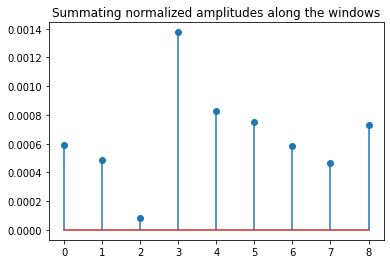

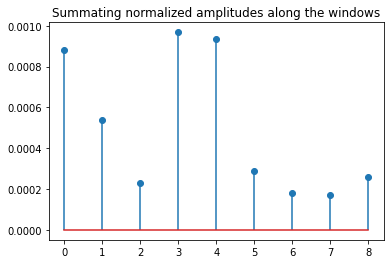

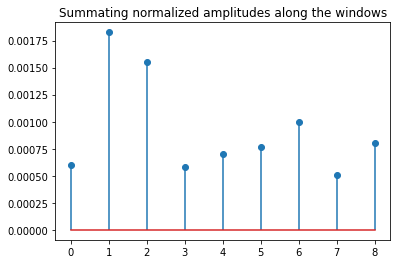

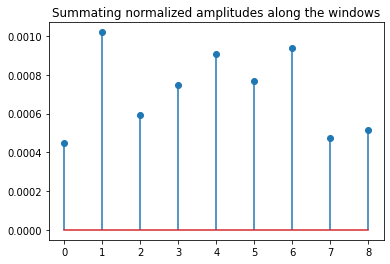

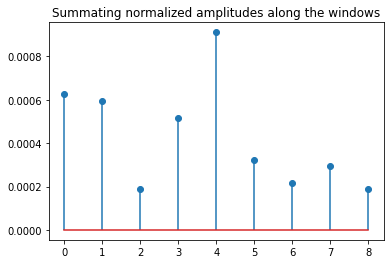

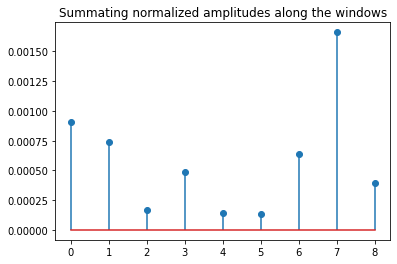

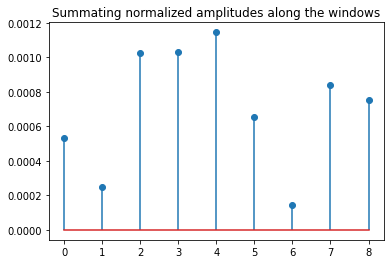

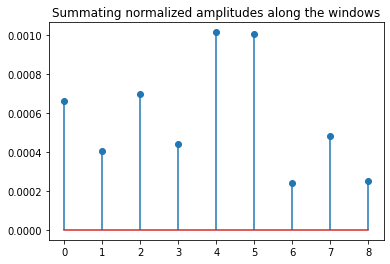

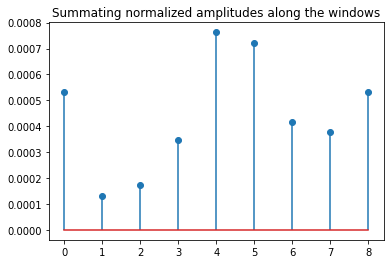

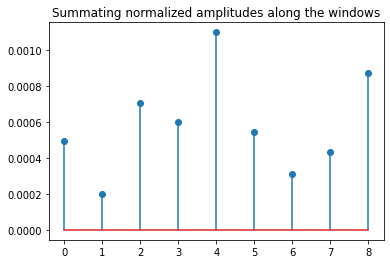

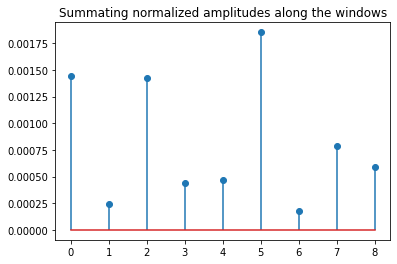

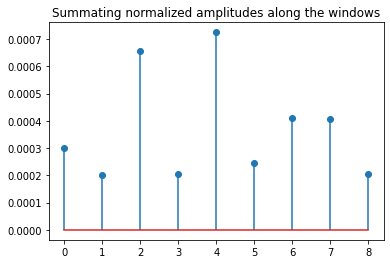

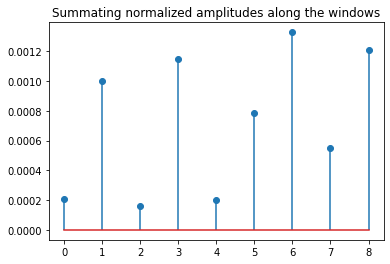

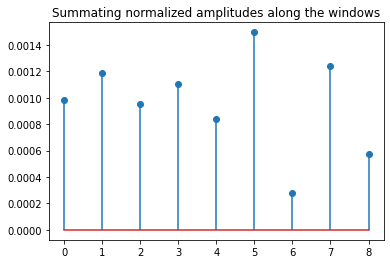

In [20]:
print(f'Frequências: {RYTHM_SERIES_DF.index}')

#TOTAL_SUM = np.zeros(WND_NUMBER)
TOTAL_SUM = np.zeros((len(RYTHM_SERIES_DF.index),WND_NUMBER))

try:
    # Getting the wished values for analysis
    #DESIRED_FREQ = float(input('Qual frequência de estimulação você deseja analisar? '))
    DESIRED_RYTHM = input('Qual ritmo fundamental você deseja analisar? ')
    
    # Montar loop para cada frequência de estimulação
    
    for INDEX,DESIRED_FREQ in enumerate(RYTHM_SERIES_DF.index):

        # Summing all values inside a rythm range, for each time-window
        for rythm_amp in RYTHM_SERIES_DF.loc[DESIRED_FREQ][DESIRED_RYTHM]:
            for wnd_number in range(WND_NUMBER):
                #TOTAL_SUM[wnd_number] += RYTHM_SERIES_DF.loc[DESIRED_FREQ][DESIRED_RYTHM][rythm_amp][wnd_number]
                TOTAL_SUM[INDEX,wnd_number] += RYTHM_SERIES_DF.loc[DESIRED_FREQ][DESIRED_RYTHM][rythm_amp][wnd_number]
                
                #print(f'Índice x (índice frequência): {INDEX}')
                #print(f'Índice y (janela): {wnd_number}')
                #print(f'Frequência: {DESIRED_FREQ}')
                #print(f'Frequência ritmo: {rythm_amp}')
                #print(f'Soma amplitude ritmo {DESIRED_RYTHM}: {TOTAL_SUM[INDEX,wnd_number]}\n')
                
    #print(f'{TOTAL_SUM}')

    for array in TOTAL_SUM:
        # Plotting results
        plt.figure()
        plt.title('Summating normalized amplitudes along the windows')
        plt.stem(range(WND_NUMBER), array)

        #plt.figure()
        #plt.title('SNR behavior along the windows')
        #plt.stem(range(WND_NUMBER), FFT_DF.loc[DESIRED_FREQ][1])
    
except:
    print('\n\nEntrada de valores não-condizentes. Favor inserir valores corretos.')

In [27]:
X = []
Y = []
Z = []

for num in range(14):
    for wnd in range(9):
        X = X + [wnd]
        
for freq in RYTHM_SERIES_DF.index:
    for num in range(9):
        Y = Y + [freq]
        
for array in TOTAL_SUM:
    for num in array:
        Z = Z + [num]

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

In [28]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

y = np.array(RYTHM_SERIES_DF.index)
y.shape = (1,14)
y = y[0,:]
x = range(WND_NUMBER)
z = RYTHM_SERIES_DF[DESIRED_RYTHM]

ax.plot3D(X, Y, Z)

ValueError: input operand has more dimensions than allowed by the axis remapping

AttributeError: 'Line3D' object has no attribute '_verts3d'

AttributeError: 'Line3D' object has no attribute '_verts3d'

<Figure size 432x288 with 1 Axes>

In [ ]:
print(RYTHM_SERIES_DF)

                                                  delta  \
freq                                                      
5.5   {0.5: [7.499735990058191e-05, 0.00014495755697...   
6.0   {0.5: [0.00017356801825688036, 0.0001023880541...   
6.5   {0.5: [0.00010498259913663429, 0.0003858340708...   
7.0   {0.5: [9.48482223595071e-05, 0.000212044573807...   
7.5   {0.5: [0.00011735974811194967, 0.0001887208903...   
8.0   {0.5: [0.00020442363385856334, 0.0001831196728...   
8.5   {0.5: [0.0001431239707445855, 5.98718344910439...   
9.0   {0.5: [0.00014947892107619744, 6.4387187510842...   
9.5   {0.5: [0.00012115046775483843, 2.4794236075125...   
10.0  {0.5: [0.0001227244130843442, 9.87092801435265...   
10.5  {0.5: [0.0003088919703726956, 0.00010760492454...   
11.0  {0.5: [6.065691413752721e-05, 2.14947886143192...   
11.5  {0.5: [5.94532498499992e-05, 0.000158567994863...   
12.0  {0.5: [0.0001359660492387158, 0.00022665312431...   

                                                  theta

In [ ]:
# Asking for rythm range to analyze
DESIRED_RYTHM = input('Qual ritmo fundamental você deseja analisar? ')

# Creating dict for storing the average amplitude for all windows inside rythm range
TOTAL_SUM_RYTHM = [nested_dict() for i in range(len(RYTHM_SERIES_DF.index))]

for index,freq in enumerate(RYTHM_SERIES_DF.index):
    TOTAL_SUM_RYTHM[index]['freq'] = freq
    TOTAL_SUM_RYTHM[index]['rythm'] = np.zeros(WND_NUMBER)

    for rythm_amp in RYTHM_SERIES_DF.loc[freq][DESIRED_RYTHM]:
        for wnd_number in range(WND_NUMBER):
            TOTAL_SUM_RYTHM[index]['rythm'][wnd_number] += RYTHM_SERIES_DF.loc[DESIRED_FREQ][DESIRED_RYTHM][rythm_amp][wnd_number]

    # Average beween windows of same index for different frequencies inside the rythm range
    TOTAL_SUM_RYTHM[index]['rythm'] = TOTAL_SUM_RYTHM[index]['rythm']//len(DESIRED_RYTHM) 

    TOTAL_SUM_RYTHM[index] = TOTAL_SUM_RYTHM[index].to_dict()

In [ ]:
print(TOTAL_SUM_RYTHM)

[{'freq': 5.5, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 6.0, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 6.5, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 7.0, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 7.5, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 8.0, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 8.5, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 9.0, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 9.5, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 10.0, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 10.5, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 11.0, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 11.5, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'freq': 12.0, 'rythm': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}]
